In [41]:
import numpy as np
from sklearn.preprocessing import normalize
import requests
# import matplotlib.pyplot as plt

# import warnings
# warnings.filterwarnings('ignore')
# %matplotlib inline
# %load_ext autoreload
# %autoreload 2


class WikiEmbedding:

    def __init__(self, fname):
        
        self.w2idx = {}
        self.idx2w = []
    
        with open(fname, 'rb') as f:
            
            try:
                m, n = next(f).decode('utf8').strip().split(' ')
                self.E = np.zeros((int(m), int(n)))

                for i, l in enumerate(f):
                    l = l.decode('utf8').strip().split(' ')
                    w = l[0]
                    self.E[i] = np.array(l[1:])
                    self.w2idx[w] = i
                    self.idx2w.append(w)
            except:
                pass
                
        self.E = normalize(self.E)
        self.idx2w = np.array(self.idx2w)

    def most_similar(self, w, n=10, min_similarity=0.5):
        """
        Find the top-N most similar words to w, based on cosine similarity.
        As a speed optimization, only consider neighbors with a similarity
        above min_similarity
        """
        
        if type(w) is str:
            w = self.E[self.w2idx[w]]

        scores = self.E.dot(w)
        # only consider neighbors above threshold
        min_idxs = np.where(scores > min_similarity)
        ranking = np.argsort(-scores[min_idxs])[1:(n+1)]
        nn_ws = self.idx2w[min_idxs][ranking]
        nn_scores = scores[min_idxs][ranking]
        return list(zip(list(nn_ws), list(nn_scores)))

In [42]:
en_embedding = WikiEmbedding('2017-01-01_2017-01-30_en_100')

In [ ]:
import pickle
s = pickle.dumps(en_embedding)


In [22]:
en_embedding.most_similar('Word2vec')
en_embedding.most_similar('Wikipedia')
en_embedding.most_similar('Orange_(fruit)')

[(u'Citrus', 0.90575250036346888),
 (u'Lemon', 0.90433957857245573),
 (u'Mandarin_orange', 0.87712923359520301),
 (u'Citrus_\xd7_sinensis', 0.86652514642650824),
 (u'Strawberry', 0.86131830739925486),
 (u'List_of_citrus_fruits', 0.85644380785608609),
 (u'Citrus_limetta', 0.85348909731183475),
 (u'Grapefruit', 0.84853186319551366),
 (u'Lime_(fruit)', 0.84316197516259872),
 (u'Tangerine', 0.83910875335493862)]

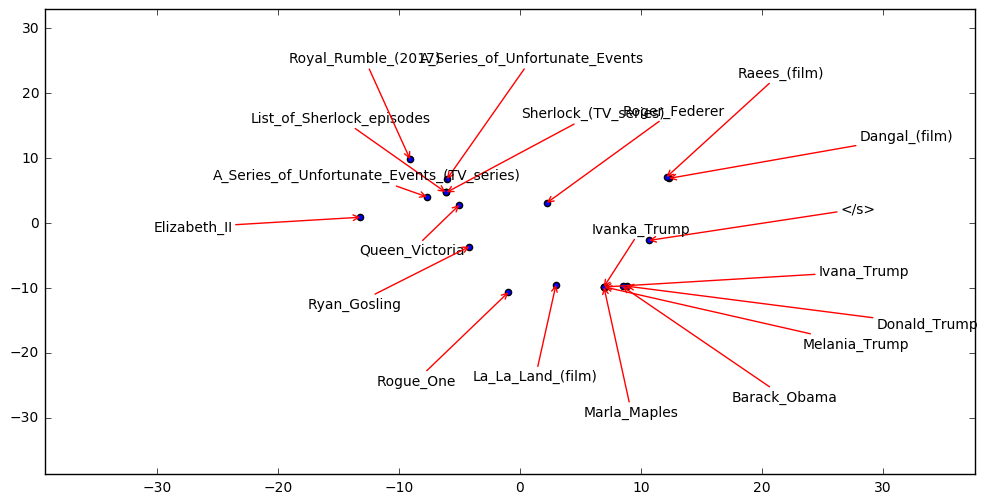

In [12]:
from getting_started_helpers import get_tsne, plot_tsne
tsne_en_embedding = get_tsne(en_embedding, pca_dim = 10, n_items=5000)
plot_tsne(en_embedding, tsne_en_embedding, n = 20)

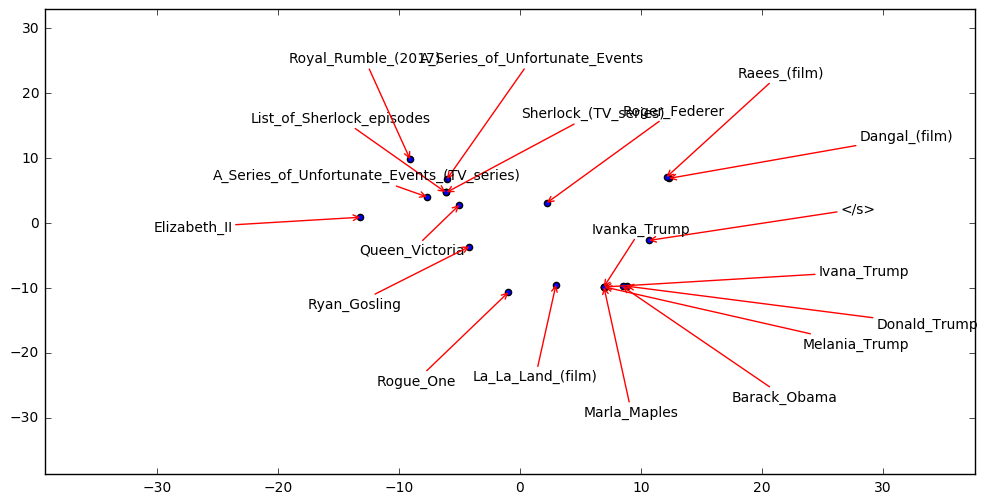

In [13]:
tsne_en_embedding = get_tsne(en_embedding, pca_dim = 10, n_items=5000)
plot_tsne(en_embedding, tsne_en_embedding, n = 20)

In [15]:
def items_to_titles(items, lang):
    """
    Input: a list of Wikidata item ids
    Output: a dictionary mapping from ids to title in lang
    
    Note: items without an articlce in lang are not included in the output
    """
    lang += 'wiki'
    payload = {'action': 'wbgetentities',
               'props': 'sitelinks/urls',
               'format': 'json',
               'ids': '|'.join(items),               
              }
    r = requests.get('https://www.wikidata.org/w/api.php', params=payload).json()
    
    return parse_wikidata_sitelinks(r, lang, True)
    
    
def titles_to_items(titles, lang):
    """
    Input: a list of article titles in lang
    Output: a dictionary mapping from titles in lang to Wikidata ids
    
    Note: articles in lang without a Wikidata id are not included in the output

    """
    lang += 'wiki'
    payload = {'action': 'wbgetentities',
               'props': 'sitelinks/urls',
               'format': 'json',
               'sites': lang,
               'titles': '|'.join(titles),
              }
    r = requests.get('https://www.wikidata.org/w/api.php', params=payload).json()
    
    return parse_wikidata_sitelinks(r, lang, False)


def parse_wikidata_sitelinks(response, lang, item_to_title):
    """
    Helper function for parsing sitelinks from Wikidata Api
    """
    d = {}
    if 'entities' not in response:
        print ('No entities in reponse')
        return d

    for item, v in response['entities'].items():
        if 'sitelinks' in v:
            if lang in v['sitelinks']:
                title = v['sitelinks'][lang]['title'].replace(' ', '_')
                if item_to_title:
                    d[item] = title
                else:
                    d[title] = item
    return d

In [16]:
def most_similar(embedding, title, lang, n=10, min_similarity=0.7):
    item = titles_to_items([title,], lang)[title]
    nn = embedding.most_similar(item, n=n, min_similarity=min_similarity)
    nn_items = [x[0] for x in nn]
    nn_items_to_titles = items_to_titles(nn_items, lang)
    return [(nn_items_to_titles[x[0]], x[1]) for x in nn if x[0] in nn_items_to_titles]

In [24]:
wikidata_embedding = WikiEmbedding('2017-01-01_2017-01-30_en_100')

In [40]:
wikidata_embedding.most_similar('Marvel_Comics', n=1000)

[(u'Marvel_Universe', 0.92795986170747025),
 (u'Martin_Goodman_(publisher)', 0.91862813511333274),
 (u'Timely_Comics', 0.91188334731260534),
 (u'Marvel_Entertainment', 0.89936129696029843),
 (u'List_of_Marvel_Comics_characters', 0.89879072333880339),
 (u'Avengers_(comics)', 0.89655736421366328),
 (u'Marvel_Studios', 0.88844476201002254),
 (u'DC_vs._Marvel', 0.88720712382456302),
 (u'List_of_Marvel_Comics_publications_(A\u2013M)', 0.88165990335711952),
 (u'List_of_Marvel_Comics_superhero_debuts', 0.87826530234448441),
 (u'American_comic_book', 0.86905682788870153),
 (u'Stan_Lee', 0.86892049732196375),
 (u'The_Avengers_(comic_book)', 0.86339051923991539),
 (u'List_of_films_based_on_Marvel_Comics', 0.86123542382640306),
 (u'Ultimate_Marvel', 0.85295243221734318),
 (u'Captain_America', 0.85169768822728098),
 (u'First_appearance', 0.84950873788950609),
 (u'Amazing_Fantasy', 0.8481713619060075),
 (u'Jack_Kirby', 0.84683173193164585),
 (u'Civil_War_(comics)', 0.84572221367955702),
 (u'Axel_Al

In [35]:
def most_similar(embedding, title, lang, n=10, min_similarity=0.7):
    item = titles_to_items([title,], lang)[title]
    print(item)
    nn = embedding.most_similar(item, n=n, min_similarity=min_similarity)
    nn_items = [x[0] for x in nn]
    nn_items_to_titles = items_to_titles(nn_items, lang)
    return [(nn_items_to_titles[x[0]], x[1]) for x in nn if x[0] in nn_items_to_titles]

en_embedding = WikiEmbedding('2016-03-01_2016-03-07_en_100')
most_similar(en_embedding, 'Universe', 'en', n=30, min_similarity=0.6)


Q1


TypeError: Cannot cast array data from dtype('float64') to dtype('<U32') according to the rule 'safe'

In [34]:
wikidata_embedding.most_similar('Universe', n=30, min_similarity=0.6)


[(u'Galaxy', 0.89506611863914742),
 (u'Dark_energy', 0.87397876086446691),
 (u'Black_hole', 0.86997443104158978),
 (u'Milky_Way', 0.86303658421284868),
 (u'Physical_cosmology', 0.8621617817408731),
 (u'Astronomical_object', 0.85306338048047703),
 (u"Earth's_location_in_the_Universe", 0.85103516361766984),
 (u'Chronology_of_the_universe', 0.84952072625055719),
 (u'Space', 0.84875642124617723),
 (u'Observable_universe', 0.84601599566054697),
 (u'Planet', 0.8437087288722106),
 (u'Galaxy_formation_and_evolution', 0.84006721440116738),
 (u'Solar_System', 0.83833913863683818),
 (u'Star_formation', 0.8345705308957021),
 (u'Matter', 0.83355563292359558),
 (u'Ultimate_fate_of_the_universe', 0.8317052018505684),
 (u'Shape_of_the_universe', 0.83064626318330248),
 (u'Metric_expansion_of_space', 0.82822769816140085),
 (u'Formation_and_evolution_of_the_Solar_System', 0.82561301534179743),
 (u'Age_of_the_universe', 0.82162298283525192),
 (u'History_of_the_center_of_the_Universe', 0.81786501592168714)